In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'BAAI/Bunny-v1_1-Llama-3-8B-V' # or 'BAAI/Bunny-Llama-3-8B-V' or 'BAAI/Bunny-v1_1-4B' or 'BAAI/Bunny-v1_0-4B' or 'BAAI/Bunny-v1_0-3B' or 'BAAI/Bunny-v1_0-3B-zh' or 'BAAI/Bunny-v1_0-2B-zh'
offset_bos = 1 # for Bunny-v1_1-Llama-3-8B-V, Bunny-Llama-3-8B-V, Bunny-v1_1-4B, Bunny-v1_0-4B and Bunny-v1_0-3B-zh
# offset_bos = 0 for Bunny-v1_0-3B and Bunny-v1_0-2B-zh

# create model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16, # float32 for cpu
    device_map='auto',
    trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/usr/local/l

In [3]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [15]:
import json
import glob

example_paths = glob.glob("data/*.json")

results = []
for example_path in example_paths:
    with open(example_path) as f:
        example = json.load(f)
    example_idx = example_path.split("/")[-1].split(".json")[0]
    a_img = Image.open("data/imgs/" + example_idx + "_a.png")
    b_img = Image.open("data/imgs/" + example_idx + "_b.png")
    image = get_concat_h(a_img, b_img)
    image_tensor = model.process_images([image], model.config).to(
        dtype=model.dtype, device="cuda"
    )
    # text prompt
    for caption_origin in ["A", "B", "A_B", "B_A"]:
        caption = example[caption_origin]
        score = example["plausibility_scores"][caption_origin]
        print(caption_origin, caption)

        prompt = f"Description: {caption}\n Does the description match any of the given images? Reply with yes or no."
        text = f"A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <image>\n{prompt} ASSISTANT:"
        text_chunks = [tokenizer(chunk).input_ids for chunk in text.split("<image>")]
        input_ids = (
            torch.tensor(
                text_chunks[0] + [-200] + text_chunks[1][offset_bos:], dtype=torch.long
            )
            .unsqueeze(0)
            .to("cuda")
        )
        # generate
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            max_new_tokens=32,
            use_cache=True,
            do_sample=False,
            repetition_penalty=1.0,  # increase this to avoid chattering
        )[0]

        # decode
        output_text = tokenizer.decode(output_ids, skip_special_tokens=True).split(
            "ASSISTANT: "
        )[-1]
        if "yes" in output_text.lower():
            results.append(
                (example_idx, caption, caption_origin, "yes", output_text, score)
            )
        elif "no" in output_text.lower():
            results.append(
                (example_idx, caption, caption_origin, "no", output_text, score)
            )
        else:
            results.append(
                (example_idx, caption, caption_origin, "unknown", output_text, score)
            )

A A cat is laying on a laptop on a bed
B An Air Plane is parked at the station. 
A_B An Air Plane is laying on a laptop
B_A An air plane is laying on a laptop on a bed
A Two chefs in a kitchen with brown wood cabinets.
B PERSON ON SKATEBOARD MAKING A JUMP UP ONTO RAMP
A_B Two chefs on skateboard making a jump
B_A Two chefs in a kitchen making a jump up onto ramp.
A A man standing in front of an old truck.
B Multiple children are getting ready to fly kites.
A_B Multiple children standing in front of an old truck.
B_A Multiple children are standing in front of an old truck.
A A guy makes a weird face as he eats what looks like a hot dog.
B A number of tourists atop two colorful trucks.
A_B A guy makes a weird face as he eats a number of tourists.
B_A A number of tourists atop two colorful trucks eating what looks like a hot dog.
A A coffee cup on a table with a chain hanging out.
B An old bell alarm clock dinging at 6:00 o'clock
A_B A coffee cup dinging at 6:00 o'clock.
B_A An old bell a

In [16]:
import pandas as pd

df = pd.DataFrame(
    results, columns=["example_idx", "caption", "caption_origin", "result", "output_text", "score"]
)

df.loc[df["caption_origin"].isin(["A", "B"])].result.value_counts()

result
yes    61
no     21
Name: count, dtype: int64

In [17]:
df.loc[df["caption_origin"].isin(["A", "B"])]

,example_idx,caption,caption_origin,result,output_text,score
0,29,A cat is laying on a laptop on a bed,A,yes,Yes,5
1,29,An Air Plane is parked at the station.,B,yes,Yes,5
4,9,Two chefs in a kitchen with brown wood cabinets.,A,yes,Yes,5
5,9,PERSON ON SKATEBOARD MAKING A JUMP UP ONTO RAMP,B,yes,Yes,5
8,0,A man standing in front of an old truck.,A,yes,Yes,5
...,...,...,...,...,...,...
153,15,An old European cathedral on a lightly cloudy day,B,yes,Yes,5
156,26,A group of stuffed animals sitting next to som...,A,no,No,3
157,26,THIS TO ME LOOKS LIKE A GIANT PIECE OF LASANGN...,B,yes,Yes,1
160,4,a toilet with no tank attached to the wall,A,yes,Yes,5


In [18]:
df.loc[df["caption_origin"].isin(["A_B", "B_A"])].result.value_counts()

result
no     59
yes    23
Name: count, dtype: int64

In [21]:
df.loc[df["caption_origin"].isin(["A_B", "B_A"])]

,example_idx,caption,caption_origin,result,output_text,score
2,29,An Air Plane is laying on a laptop,A_B,no,No,3
3,29,An air plane is laying on a laptop on a bed,B_A,no,No,3
6,9,Two chefs on skateboard making a jump,A_B,no,No,3
7,9,Two chefs in a kitchen making a jump up onto r...,B_A,no,No,3
10,0,Multiple children standing in front of an old ...,A_B,no,No,5
...,...,...,...,...,...,...
155,15,An old European cathedral near gas station.,B_A,yes,Yes,3
158,26,A giant lasagna pizza sitting next to some ducks.,A_B,yes,Yes,3
159,26,This group of stuffed animals looks like a gia...,B_A,no,No,3
162,4,A group of young Asian men are playing soccer ...,A_B,no,No,3


<Axes: xlabel='fake_caption', ylabel='correct'>

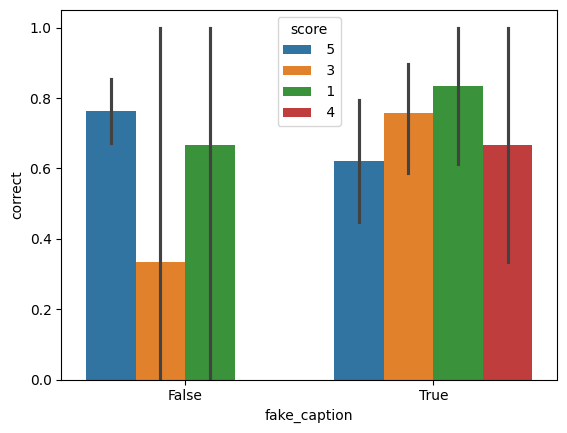

In [30]:
import seaborn as sns

df["correct"] = 0
df.loc[df["caption_origin"].isin(["A", "B"]) & (df["result"] == "yes"), "correct"] = 1
df.loc[
    df["caption_origin"].isin(["A_B", "B_A"]) & (df["result"] == "no"), "correct"
] = 1

df["fake_caption"] = df["caption_origin"].isin(["A_B", "B_A"])

sns.barplot(x="fake_caption", y="correct", data=df, hue="score")

In [7]:
df.loc[df["caption_origin"].isin(["A", "B"])].output_text[0]

'Yes'

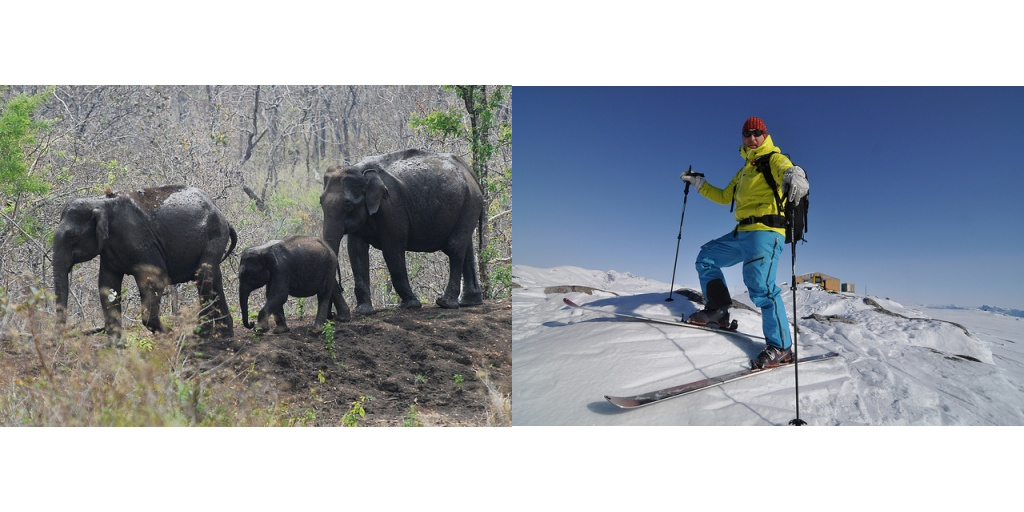

In [43]:
a_img = Image.open("data/imgs/" + str(9) + "_a.png")
b_img = Image.open("data/imgs/" + str(9) + "_b.png")
image = get_concat_h(a_img, b_img)
image